Import libraries and try to load environments from `.env`

In [38]:
from pathlib import Path
import treetaggerwrapper
import matplotlib.pyplot as plt

try:
    from dotenv import load_dotenv

    load_dotenv()
except ImportError:
    pass

In [39]:
coca_file = Path('coca20000.txt')
ce_pron_file = Path('ce_pronunciation.txt')
se_pron_file = Path('se_pronunciation.txt')

Get desired ce- and se-words

In [40]:
def get_ce_se_words():
    # 1. Select words that consist only of Latin letters
    all_words: list[str] = []
    letters = range(ord('a'), ord('z') + 1)
    content = coca_file.read_text(encoding='utf-8')
    for line in content.split('\n'):
        for char in line.strip():
            if ord(char.lower()) not in letters:
                break
        else:
            all_words.append(line.strip())
    all_words = list(set(all_words))

    # 2. Get ce- and se-words
    ce_words: list[str] = []
    se_words: list[str] = []
    for word in all_words:
        # skip proper names
        if not word.islower():
            continue
        # skip 'fiance'
        if word == 'fiance':
            continue
        if word[-2:] == 'ce':
            ce_words.append(word)
        elif word[-2:] == 'se':
            se_words.append(word)
    return all_words, ce_words, se_words


all_words, ce_words, se_words = get_ce_se_words()
print(f'Latin words: {len(all_words)}, ce-words: {len(ce_words)}, se-words: {len(se_words)}')

Latin words: 16903, ce-words: 324, se-words: 241


Analyze part of speech (POS) using `TreeTagger`

In [41]:
def analyze_pos():
    # convert tags generated by TreeTagger to simple POS
    tag2pos: dict[str, str] = {
        'NN0': 'Noun',
        'NN1': 'Noun',
        'NN2': 'Noun',
        'VVB': 'Verb',
        'VVD': 'Verb',
        'VVI': 'Verb',
        'PRP': 'Prep',
        'AJ0': 'Adj',
        'AJC': 'Adj',
        'AJS': 'Adj',
        'AV0': 'Adv',
        'AVQ': 'Adv',
        'DT0': 'Det',
        'DTQ': 'Det',
        'CJS': 'Conj',
    }
    tagger = treetaggerwrapper.TreeTagger(TAGLANG='en')
    ce_pos: dict[str, str] = {}
    se_pos: dict[str, str] = {}
    for tar_words, tar_pos in ((ce_words, ce_pos), (se_words, se_pos)):
        for word in tar_words:
            res: list[str] = tagger.tag_text(word)
            tag = res[0].split('\t')[1]
            pos = tag2pos[tag]
            tar_pos[word] = pos
    return ce_pos, se_pos


ce_pos, se_pos = analyze_pos()
assert ce_pos.keys() == set(ce_words) and se_pos.keys() == set(se_words)

### Analyze sound pattern of ce- and se-words

`ce_pronunciation.txt` and `se_pronunciation.txt` were generated using website `https://tophonetics.com/`, where "American transcriptions" option was chosen. Note that the website fails to transcript some words such as "salience" and "pillowcase", so I just refer to the online Oxford English Dictionary (`https://www.oed.com/`) for those words.

In [42]:
def get_pronunciation():
    ce_pron: dict[str, str] = {}
    se_pron: dict[str, str] = {}
    for tar_file, tar_pron in ((ce_pron_file, ce_pron), (se_pron_file, se_pron)):
        content = tar_file.read_text(encoding='utf-8')
        for line in content.split('\n'):
            # print(line)
            word, pron = line.strip().split('\t')
            tar_pron[word] = pron
    return ce_pron, se_pron


ce_pron, se_pron = get_pronunciation()
assert ce_pron.keys() == set(ce_words) and se_pron.keys() == set(se_words)

In [69]:
def analyze_sound():
    vowels = ['eɪ', 'aɪ', 'ɔɪ', 'aʊ', 'əʊ', 'iə', 'ɛə', 'ʊə', 'iː', 'ɔː', 'ɜː', 'uː', 'ɑː', 'ɪ', 'ə', 'ɒ', 'ʊ', 'ʌ', 'ɛ', 'æ']
    # {phoneme: {pos: count}}
    ce_phoneme_pos: dict[str, dict[str, int]] = {}
    se_phoneme_pos: dict[str, dict[str, int]] = {}
    # for each vowel followed by /s/ or /z/, calculate the number of nouns and verbs
    for tar_words, tar_pos, tar_pron, tar_result in (ce_words, ce_pos, ce_pron, ce_phoneme_pos), (se_words, se_pos, se_pron, se_phoneme_pos):
        for word in tar_words:
            pos, pron = tar_pos[word], tar_pron[word]
            if not pron[-1] in {'s', 'z'}:
                print(f'{word} is not ended with /s/ or /z/')
                continue
            for vow in vowels:
                if pron[:-1].endswith(vow):
                    tar_result[vow][pos] = tar_result.setdefault(vow, {}).get(pos, 0) + 1
                    break
            else:
                cons = pron[-2]
                tar_result[cons][pos] = tar_result.setdefault(cons, {}).get(pos, 0) + 1
    return ce_phoneme_pos, se_phoneme_pos


ce_phoneme_pos, se_phoneme_pos = analyze_sound()

posse is not ended with /s/ or /z/


### Plot POS-sound pattern

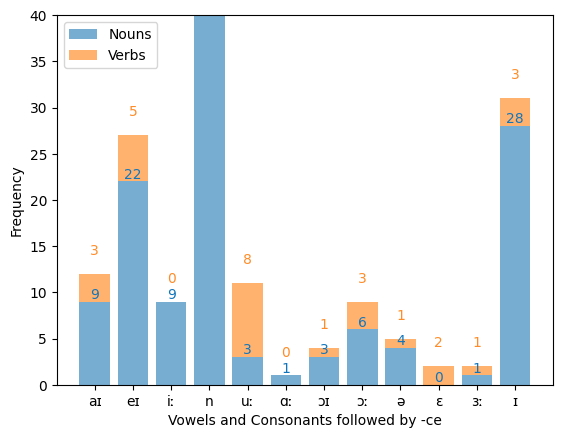

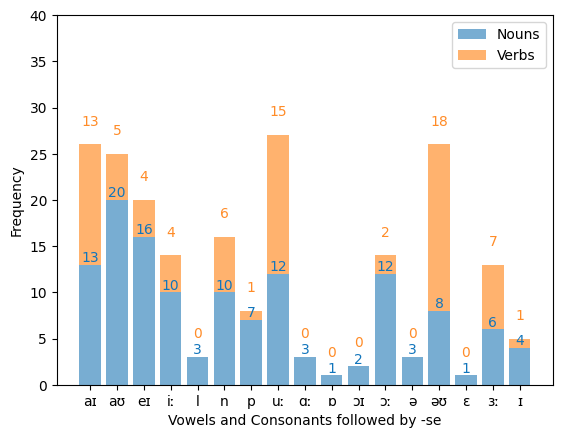

In [ ]:
def plot_sound_pattern():
    for name, data in (('-ce', ce_phoneme_pos), ('-se', se_phoneme_pos)):
        keys = sorted(data)

        nouns = [data[k].get('Noun', 0) for k in keys]
        verbs = [data[k].get('Verb', 0) for k in keys]

        plt.figure()

        nouns_bar = plt.bar(keys, nouns, label='Nouns', alpha=0.6)
        plt.bar_label(nouns_bar, nouns, c='#1175bc', fmt=lambda x: f'{x:.0f}    ')

        verbs_bar = plt.bar(keys, verbs, bottom=nouns, label='Verbs', alpha=0.6)
        verb_labels = [f'{x}\n' for x in verbs]
        plt.bar_label(verbs_bar, verb_labels, c='#ff8c28', fmt=lambda x: f'{x:.0f}\n')

        plt.ylim(top=40)
        plt.xlabel(f'Vowels and Consonants followed by {name}')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()


plot_sound_pattern()